# hVAE

In [2]:
import torch

from src.hvae import hVAE
from hparams import get_hparams

PATH = "/Users/laszlofreund/code/ai/hvae/experiments/TDVAE/2023-08-27__23-49/checkpoints/checkpoint-0.pth"
#dataset = get_hparams().data_params.dataset
#test_loader = dataset.get_test_loader()

hvae = hVAE.load(PATH)
#hvae.test_model(test_loader)
hvae.summary()

FileNotFoundError: [Errno 2] No such file or directory: 'data/textures/datasets'

In [2]:
import tensorflow as tf

tfc = tf.compat.v1
tfc.disable_eager_execution()
output_sd_placeholder = tfc.placeholder(tf.float32, shape=[], name='output_sd')

import tensorflow_probability as tfp

dist = tfp.distributions.Normal(loc=0., scale=output_sd_placeholder)

In [3]:
dist.sample()

<tf.Tensor 'Normal/sample/Reshape:0' shape=() dtype=float32>

In [4]:
import numpy as np
steps_per_epoch = 640000 // 128
beta_y = np.concatenate((np.full(500 * steps_per_epoch, 0.1),
                         np.linspace(0.1, 1.25, 1150 * steps_per_epoch)))

In [5]:
beta_y

array([0.1      , 0.1      , 0.1      , ..., 1.2499996, 1.2499998,
       1.25     ])

In [8]:
import torch
logits = torch.rand(10, 2)
probs = torch.ones_like(logits)

In [9]:
probs

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [10]:
dist = torch.distributions.OneHotCategorical(probs=probs)

In [13]:
dist.sample()

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [36]:
def construct_prior_probs(batch_size, n_y, n_y_active):
    """Construct the uniform prior probabilities.

    Args:
      batch_size: int, the size of the batch.
      n_y: int, the number of categorical cluster components.
      n_y_active: tf.Variable, the number of components that are currently in use.

    Returns:
      Tensor representing the prior probability matrix, size of [batch_size, n_y].
    """
    probs = torch.ones((batch_size, 1))
    return probs

In [37]:
probs = construct_prior_probs(10, torch.tensor(1), torch.tensor(1))

TypeError: pad(): argument 'pad' (position 2) must be tuple of ints, not Tensor

In [93]:
from meitorch import mei
from src.checkpoint import Checkpoint

In [94]:
experiment = Checkpoint.load("../experiments/TDVAE40n_migrate/migration/2023-09-19__21-11/migrated_checkpoint.pth")

In [95]:
model = experiment.get_model()

In [96]:
target_block = "y"

In [337]:
from src.hvae.model import compute_loss
import torch

def custom_loss(x):
    x.to("cpu")
    computed, distributions = model(x, use_mean=True)
    losses = compute_loss(x, distributions)
    to_query = computed[target_block]
    contrast = torch.std(to_query)
    to_add = - losses["kl_div"] * 0.01
    print(to_query[0][207], losses["kl_div"], contrast)
    return to_query, to_add

def get_target_block(x):
    compute_function = model.compute_function(target_block)
    computed, distributions = compute_function(x, use_mean=True)
    return computed[target_block]

In [338]:
model.to("cpu")
def conf(n):
    return dict(
        neuron_query=n,
        custom_loss=custom_loss,
        iter_n=10000,  # number of iterations
        start_sigma=1.5,
        end_sigma=0.5,
        start_step_size=3.0,
        end_step_size=0.125,
        precond=0,  # strength of gradient preconditioning filter falloff
        step_gain=0.001,  # scaling of gradient steps
        jitter=0,  # size of translational jittering
        blur=False,
        norm=-1,  # norm adjustment after step, negative to turn off
        train_norm=-1,  # norm adjustment during step, negative to turn off
        clip=True  # Whether to clip the range of the image to be in valid range
    )

In [339]:
from matplotlib.pyplot import imshow, show
Mei = mei.MEI(models=[get_target_block], shape=(1, 40, 40), device="cpu")

In [ ]:
meip = Mei.generate(**conf(207))

tensor(-0.0131, grad_fn=<SelectBackward0>) tensor(7.7263e-05, grad_fn=<DivBackward0>) tensor(0.1943, grad_fn=<StdBackward0>)
tensor(-0.0152, grad_fn=<SelectBackward0>) tensor(7.5167e-05, grad_fn=<DivBackward0>) tensor(0.1935, grad_fn=<StdBackward0>)
tensor(-0.0149, grad_fn=<SelectBackward0>) tensor(7.5179e-05, grad_fn=<DivBackward0>) tensor(0.1935, grad_fn=<StdBackward0>)
tensor(-0.0145, grad_fn=<SelectBackward0>) tensor(7.5195e-05, grad_fn=<DivBackward0>) tensor(0.1936, grad_fn=<StdBackward0>)
tensor(-0.0141, grad_fn=<SelectBackward0>) tensor(7.5211e-05, grad_fn=<DivBackward0>) tensor(0.1936, grad_fn=<StdBackward0>)
tensor(-0.0137, grad_fn=<SelectBackward0>) tensor(7.5227e-05, grad_fn=<DivBackward0>) tensor(0.1936, grad_fn=<StdBackward0>)
tensor(-0.0133, grad_fn=<SelectBackward0>) tensor(7.5245e-05, grad_fn=<DivBackward0>) tensor(0.1936, grad_fn=<StdBackward0>)
tensor(-0.0130, grad_fn=<SelectBackward0>) tensor(7.5264e-05, grad_fn=<DivBackward0>) tensor(0.1937, grad_fn=<StdBackward0>)


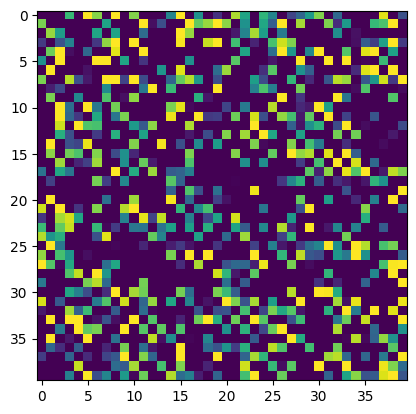

Activation:  0.30190283
Monotonic:  False
Max contrast:  0.35224142346660864
Max activation:  0.30190283
Saturation contrast:  0.35224142346660864
Image mean:  0.241517296934544
Limited contrast:  0.35224142346660864
Point rf:  None


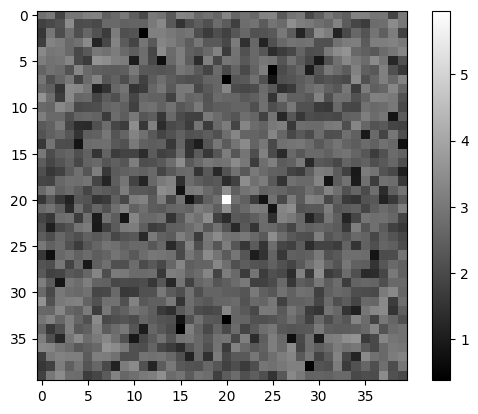

In [328]:
imshow(meip.image[0])
show()

meip.show_results()
x = meip.spatial_frequency()

In [29]:
from meitorch import gabor

Gabor = gabor.Gabor(models=[get_target_block], shape=(1, 40, 40), device="cpu")

100%|██████████| 5/5 [01:06<00:00, 13.37s/it]


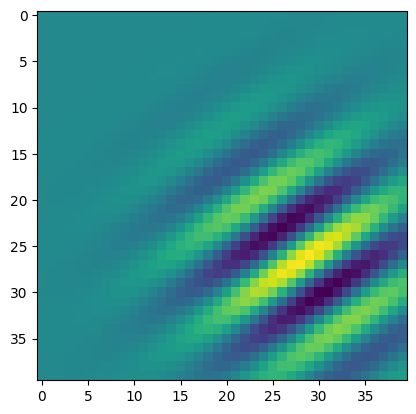

Activation:  1.4687581062316895
Phase:  [109.81217555438226]
Wavelength:  [8.54614070653593]
Orientation:  [34.05744235378624]
Sigma:  [9.0]
Dy:  [0.1751935672733563]
Dx:  [0.2391531326506794]


In [33]:
gaborp = Gabor.optimal_gabor(0)

imshow(gaborp.image)
show()

gaborp.show_results()

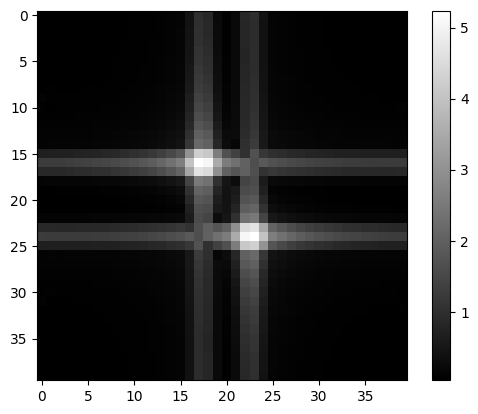

(array([ 0.   ,  0.025,  0.05 ,  0.075,  0.1  ,  0.125,  0.15 ,  0.175,
         0.2  ,  0.225,  0.25 ,  0.275,  0.3  ,  0.325,  0.35 ,  0.375,
         0.4  ,  0.425,  0.45 ,  0.475, -0.5  , -0.475, -0.45 , -0.425,
        -0.4  , -0.375, -0.35 , -0.325, -0.3  , -0.275, -0.25 , -0.225,
        -0.2  , -0.175, -0.15 , -0.125, -0.1  , -0.075, -0.05 , -0.025]),
 array([ 0.   ,  0.025,  0.05 ,  0.075,  0.1  ,  0.125,  0.15 ,  0.175,
         0.2  ,  0.225,  0.25 ,  0.275,  0.3  ,  0.325,  0.35 ,  0.375,
         0.4  ,  0.425,  0.45 ,  0.475, -0.5  , -0.475, -0.45 , -0.425,
        -0.4  , -0.375, -0.35 , -0.325, -0.3  , -0.275, -0.25 , -0.225,
        -0.2  , -0.175, -0.15 , -0.125, -0.1  , -0.075, -0.05 , -0.025]),
 array([[0.04377065, 0.04378361, 0.04446907, ..., 0.04520516, 0.04446907,
         0.04378361],
        [0.04393173, 0.04403084, 0.04467752, ..., 0.04532488, 0.04459606,
         0.04386526],
        [0.04437386, 0.04457077, 0.04518242, ..., 0.04571919, 0.04501448,
         0

In [139]:
gaborp.spatial_frequency()

In [78]:
from src.hparams import get_hparams
import sys
sys.path.append("..")
dataset = get_hparams().data_params.dataset(**get_hparams().data_params.params)

In [91]:
image = next(iter(dataset.get_train_loader()))[3]

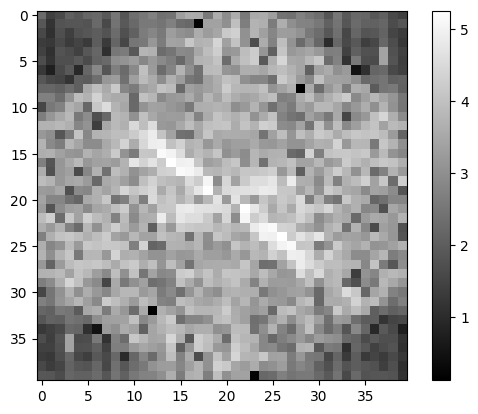

In [92]:
spat = mei.MEI.compute_spatial_frequency(image)

In [93]:
torch.std(image)

tensor(1.0538)

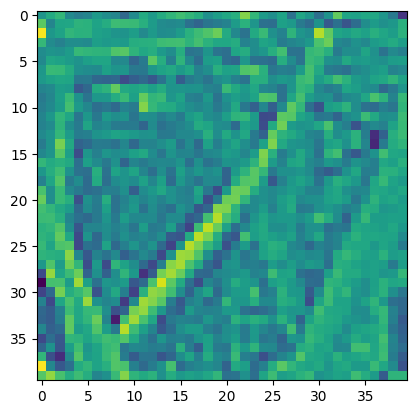

In [94]:
imshow(image[0])
show()

In [25]:
x = model(torch.randn(1, 1, 40, 40, requires_grad=True).to("mps"))

In [19]:
model.train()

hVAE(
  (input_block): InputBlock(
    (net): SerializableSequential(
      (0): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (output_block): SimpleGenBlock(
    (prior_net): SerializableSequential(
      (0): SerializableSequential(
        (0): MLPNet(
          (activation): Softplus(beta=1, threshold=20)
          (mlp_layers): Sequential(
            (0): Linear(in_features=1800, out_features=1600, bias=True)
          )
        )
      )
      (1): SerializableSequential(
        (0): Unflatten(dim=1, unflattened_size=(1, 40, 40))
      )
      (2): SerializableSequential(
        (0): FixedStdDev()
      )
    )
  )
  (encoder): Encoder(
    (blocks): OrderedModuleDict(
      (_values): ModuleList(
        (0): SimpleBlock(
          (net): SerializableSequential(
            (0): MLPNet(
              (activation): Softplus(beta=1, threshold=20)
              (mlp_layers): Sequential(
                (0): Linear(in_features=1600, out_features=2000, bias=True)
                (1

In [21]:
input = torch.randn(1, 1, 40, 40, requires_grad=True).to("mps")

In [34]:
input.retain_grad()

In [35]:
result = get_target_block(input)

In [36]:
result[target_block][0][0].backward()

In [41]:
print(input.grad)

None


In [42]:
result[target_block][0].grad.data

/var/folders/2g/v1v3hs4n5cdbqwvnh0ww1xkr0000gn/T/ipykernel_73847/3776251793.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:491.)
  result[target_block][0].grad.data


AttributeError: 'NoneType' object has no attribute 'data'

In [29]:
input.grad

/var/folders/2g/v1v3hs4n5cdbqwvnh0ww1xkr0000gn/T/ipykernel_73847/4290401996.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:491.)
  input.grad


In [43]:
layer = torch.nn.Linear(20, 40)
input = torch.randn(128, 20, requires_grad=True)
output = layer(input)
loss = output[0, 0].sum()
print(loss)
loss.backward()

tensor(-0.1945, grad_fn=<SumBackward0>)


In [45]:
print(input.grad.data)

tensor([[ 0.1106, -0.1067,  0.2179,  ...,  0.0205,  0.2205, -0.1221],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
